In [1]:
# No baffles
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
import math

#from poppy.optics import AnalyticOpticalElement
from poppy.optics import AnalyticOpticalElement, CircularAperture
from poppy.poppy_core import Wavefront, PlaneType, BaseWavefront
from poppy.fresnel import FresnelWavefront

from poppy.wfe import WavefrontError

figsize = (15,10)
figsize_small=(10,6)

Here we model EXCLAIM's off-axis beams in the focal plane through phase delays on the plane wave element of the Gaussian beams.

The focal plane is organized as an array of six lenslets organized in a normal hexagonal pattern, each with a diameter of 4mm, located 4.5mm from the center. The beam waists at the lenslets, as calculated by Negar Ehsan, are [1.618,1.616,1.680,1.715,1.708] mm for frequencies [420,470,480,520,540] GHz.

Here we model the effect of the off-axis lenslet sources using poppy, with our output beam at the position of the cold stop, 24cm from the focal plane.

We assume a Gaussian beam of the form
\begin{equation}
    u(r,z) = \sqrt{\frac{2}{\pi w^2}} exp \left [ -\frac{r^2}{w^2} - ikz - i\frac{\pi r^2}{\lambda R} + i\phi \right ]
\end{equation}

Here, z is the path length, r is the direction transverse to the direction of propagation, and R is the radius of curvature for the spherical element of the Gaussian wavefront.

The plane wave element of the beam in the focal plane will have a different path length, depending on the distance x from the center of the focal plane:
\begin{equation}
    z \rightarrow z' = \sqrt{z^2 + x^2} = z + \frac{x^2}{2z}
\end{equation}

where x<<z. Thus, the plane wave term receives a correction to the phase
\begin{equation}
    \Delta \phi(x) = -i \frac{k x^2}{2z}
\end{equation}

We model the phase difference to the lenslet-cold stop system through the above equation with z=24cm the distance to the cold stop.

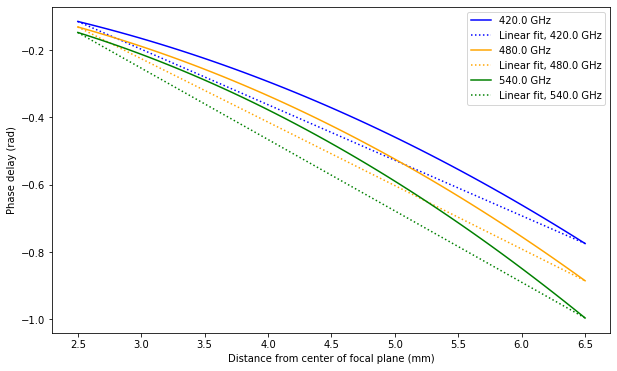

In [2]:
freqs = [420,480,540]
w_array = [1.618*u.mm,1.680*u.mm,1.708*u.mm]

z0 = 24*u.cm

x1 = 2.5*u.mm
x2 = 4.5*u.mm
x3 = 6.5*u.mm

x_array = np.linspace(x1.value,x3.value,50)
phase_slope_array = np.empty(len(freqs))

colors=['blue','orange','green']
plt.figure(figsize=(10,6))
for freq_ind,freq in enumerate(freqs):
    k = 2*np.pi*freq*u.GHz/const.c
    plt.plot(x_array,(-k*(x_array*u.mm)**2/(2*z0)).to(1),
             label=freq*u.GHz,color=colors[freq_ind])
    
    phase_0 = (-k*(x_array[0]*u.mm)**2/(2*z0)).to(1)
    phase_1 = (-k*(x_array[-1]*u.mm)**2/(2*z0)).to(1)
    linfit = np.linspace(phase_0,phase_1,len(x_array))
    plt.plot(x_array,linfit,
            label='Linear fit, '+str(freq*u.GHz),color=colors[freq_ind],linestyle=':')
    
    phase_slope_array[freq_ind] = (phase_0-phase_1)/(x_array[0]-x_array[-1])
    
plt.xlabel('Distance from center of focal plane (mm)')
plt.ylabel('Phase delay (rad)')
plt.legend()
plt.show()
plt.close()

We now model the beam from the lenslet to the lens using poppy, creating our own phase element used to introduce the linear phase gradient. 

In [3]:
class phase_gradient(WavefrontError):
    def __init__(self,x_center_offset,d_z,freq, **kwargs):
        super(WavefrontError, self).__init__(name='Phase Gradient', **kwargs)
        
        self.x_center_offset=x_center_offset
        self.d_z=d_z
        self.freq=freq
    
    def get_opd(self, wave):
        """
        Parameters
        ----------
        wave : poppy.Wavefront (or float)
            Incoming Wavefront before this optic to set wavelength and
            scale, or a float giving the wavelength in meters
            for a temporary Wavefront used to compute the OPD.
        """

        y, x = self.get_coordinates(wave)*u.m  # in meters
        k=2*np.pi*self.freq/const.c

        opd = -((x.to(u.cm)+self.x_center_offset.to(u.cm))**2/(2*self.d_z)).to(u.m).value
        
        return opd
    

In [4]:
w0_lenslet = w_array[1]
cold_stop_radius =  4.891*u.cm

lenslet_aperture = poppy.GaussianAperture(w=w0_lenslet,pupil_diam=0.4*u.cm)
lenslet_stop = poppy.CircularAperture(radius=2*u.mm)
lens_stop = poppy.CircularAperture(radius=cold_stop_radius)

d_lenslet_lens = 24*u.cm

f_lens = 24 * u.cm

lens_obj = poppy.QuadraticLens(f_lens)

"\nintensity_array = wf_center.intensity\nfig = plt.figure(figsize=(10,6))\nplt.plot(x[half_array_length,:]*100,10*np.log10(intensity_array[half_array_length,:]))\nplt.axvline(x=.2,linestyle=':')\nplt.axvline(x=-.2,linestyle=':')\nplt.xlabel('Distance from center (cm)')\nplt.ylabel('Magnitude (dB)')\n#plt.yscale('log')\nplt.legend()\nplt.show()\n\nphase_array = wf_center.phase\nfig = plt.figure(figsize=(10,6))\nplt.plot(x[half_array_length,:]*100,phase_array[half_array_length,:])\nplt.axvline(x=.2,linestyle=':')\nplt.axvline(x=-.2,linestyle=':')\nplt.xlabel('Distance from center (cm)')\nplt.ylabel('Phase (rad)')\n#plt.yscale('log')\nplt.legend()\nplt.show()"

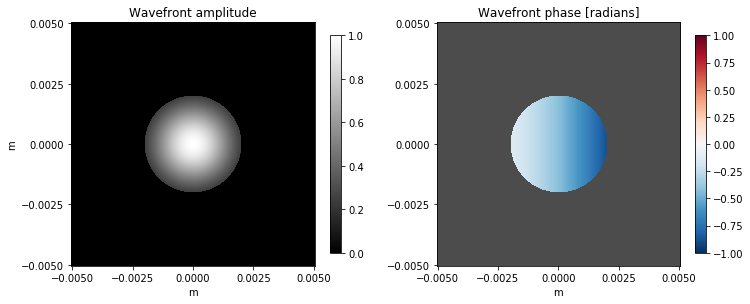

In [5]:
ll=const.c/(freqs[1]*u.GHz)

wf_center = poppy.FresnelWavefront(beam_radius=w0_lenslet*3,wavelength=ll,npix=4096)
wf_center *= lenslet_aperture
wf_center*=lenslet_stop
#print(wf_center.coordinates()[0])

wf_center *= phase_gradient(4.5*u.mm,d_lenslet_lens,freqs[1]*u.GHz)
#wf_center *= poppy.SineWaveWFE()

plt.figure(figsize=(12,5))
wf_center.display('both', colorbar=True)

y, x = wf_center.coordinates()
#print(z0.shape)
array_length = wf_center.shape[0]
half_array_length = int(wf_center.shape[0]/2)

"""
intensity_array = wf_center.intensity
fig = plt.figure(figsize=(10,6))
plt.plot(x[half_array_length,:]*100,10*np.log10(intensity_array[half_array_length,:]))
plt.axvline(x=.2,linestyle=':')
plt.axvline(x=-.2,linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Magnitude (dB)')
#plt.yscale('log')
plt.legend()
plt.show()

phase_array = wf_center.phase
fig = plt.figure(figsize=(10,6))
plt.plot(x[half_array_length,:]*100,phase_array[half_array_length,:])
plt.axvline(x=.2,linestyle=':')
plt.axvline(x=-.2,linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Phase (rad)')
#plt.yscale('log')
plt.legend()
plt.show()"""

[-30.45510684 -30.44767152 -30.44023619 ...  30.43280086  30.44023619
  30.44767152]


/opt/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


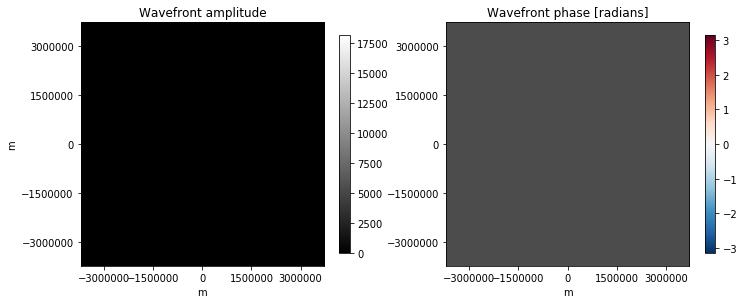

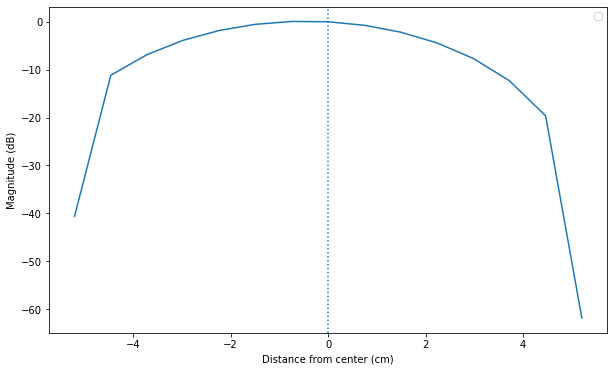

In [6]:
wf_center.propagate_fresnel(d_lenslet_lens)
wf_center*=lens_stop

plt.figure(figsize=(12,5))
wf_center.display('both', colorbar=True)


y, x = wf_center.coordinates()
#print(z0.shape)
array_length = wf_center.shape[0]
half_array_length = int(wf_center.shape[0]/2)
intensity_max = wf_center.intensity[half_array_length,half_array_length]
print(x[0])

intensity_array = wf_center.intensity/intensity_max
fig = plt.figure(figsize=(10,6))
plt.plot(x[half_array_length,:]*100,10*np.log10(intensity_array[half_array_length,:]))
plt.axvline(x=0,linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Magnitude (dB)')
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

[-49.48954862 -49.47746621 -49.4653838  ...  49.45330139  49.4653838
  49.47746621]


/opt/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


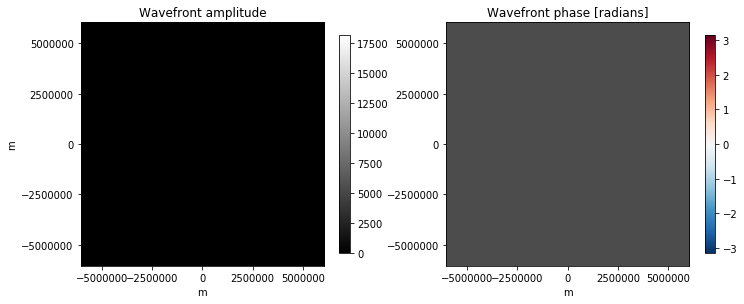

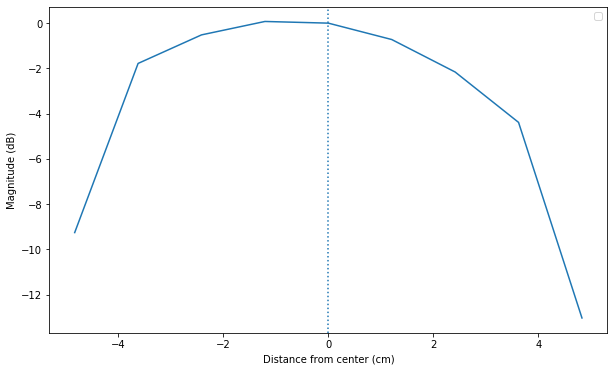

In [7]:
wf_center.propagate_fresnel(15*u.cm)
wf_center*=lens_stop

plt.figure(figsize=(12,5))
wf_center.display('both', colorbar=True)


y, x = wf_center.coordinates()
#print(z0.shape)
array_length = wf_center.shape[0]
half_array_length = int(wf_center.shape[0]/2)
intensity_max = wf_center.intensity[half_array_length,half_array_length]
print(x[0])

intensity_array = wf_center.intensity/intensity_max
fig = plt.figure(figsize=(10,6))
plt.plot(x[half_array_length,:]*100,10*np.log10(intensity_array[half_array_length,:]))
plt.axvline(x=0,linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Magnitude (dB)')
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

/opt/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


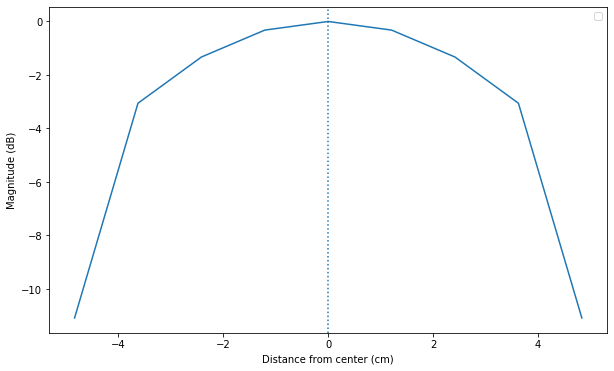

In [9]:
intensity_array = wf_center.intensity/intensity_max
fig = plt.figure(figsize=(10,6))
plt.plot(y[:,half_array_length]*100,10*np.log10(intensity_array[:,half_array_length]))
plt.axvline(x=0,linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Magnitude (dB)')
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()